In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
import re
import json
import requests
import subprocess
import glob
import os
import shapely

In [3]:
#!pip install geopandas
#!pip install fuzzywuzzy
#!pip install turfpy
#pip install pygeos

In [3]:
from shapely.geometry import Point
shapely.speedups.disable()
import geopandas as gpd
import pygeos
from geopandas import GeoDataFrame

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [5]:
# get data: Towing Report from Montgomery Data into  pandas, then transform to geopanda dataframe later in program
#towing = pd.DataFrame(requests.get('https://data.montgomerycountymd.gov/resource/i6vn-3s6e.json').json())
url = 'https://data.montgomerycountymd.gov/api/views/i6vn-3s6e/rows.csv?accessType=DOWNLOAD'
towing = pd.read_csv(url)
towing



,Tow Date,Vehicle Year,Vehicle Make,Vehicle Model,Tow Reason,Storage Company,Notes,Incident Date,Location,City,Geo-location field
0,04/30/2020,2019.0,JEEP,NaN,NOP,TCL,NaN,05/02/0020,19757 CRYSTAL ROCK DR,GERMANTOWN,POINT (-77.261484 39.179888)
1,06/13/2020,2015.0,JEEP,GCH,FIRE,TCL,NaN,06/15/0020,20107 TORREY POND PL,MONTGOMERY VILLAGE,POINT (-77.204705 39.185963)
2,05/21/2020,2005.0,GMC,NaN,FIRE,tcl,FIRE LANE // HENRYS 301-927-0007 // TCL,05/23/0020,6660 EAMES WAY,BETHESDA,NaN
3,04/17/2020,2015.0,HYUN,ACC,NOP,A&M,NOP A&M 301-421-0953,04/19/0020,100 BLK BOWSPRIT CT,GAITHERSBURG,NaN
4,05/24/2020,2015.0,MINI,COOPER,NOP,tcl,NO PERMIT // AUBURN // 301-977-2740 // TCL,05/26/0020,ARIZONA CIR / WESTLAKE DR,BETHESDA,NaN
...,...,...,...,...,...,...,...,...,...,...,...
20981,02/16/2021,2000.0,HOND,ACC,PKG,tcl,HENRYS ./ 301-927-0007 FIRE LN / TCL,02/18/0021,3536 GENTRY RIDGE CT,SILVER SPRING,POINT (-76.939653 39.072248)
20982,02/10/2021,2002.0,BMW,330,NOP,authorized,NOP // AUTHORIZED 301-562-4020 // TCL,10/23/0002,14120 WEEPING WILLOW DR,SILVER SPRING,POINT (-77.06692 39.088854)
20983,02/24/2021,2019.0,HYUN,SFE,PKG,TCL,AUTHORIZED // 301 562 4020 // HANDICAPPED PKG ...,02/26/0021,14120 WEEPING WILLOW DR,SILVER SPRING,POINT (-77.06692 39.088854)
20984,01/15/2021,1998.0,HOND,CIV,EXP,DRIVE,EXP PERMIT -TCL DRIVE 301-585-8808,01/17/0021,8658 PINEY BRANCH RD,SILVER SPRING,POINT (-76.999533 38.998597)


In [6]:
#Rename columns
towing.columns = ["tow_date", "vehicle_year", "vehicle_make", "vehicle_model", "tow_reason", "storage_company", "notes", "incident_date", "location", "city", "geo_location"]
        

In [7]:
#capitalize on first letter of each string in towing.notes, towing.story_company, towing.location, towing.city
towing.loc[:,"notes"] = towing.loc[:,"notes"].str.title()
towing.loc[:,"storage_company"] = towing.loc[:,"storage_company"].str.title()
towing.loc[:,"location"] = towing.loc[:,"location"].str.title()
towing.loc[:,"city"] = towing.loc[:,"city"].str.title()
towing.head()
towing.dtypes

tow_date            object
vehicle_year       float64
vehicle_make        object
vehicle_model       object
tow_reason          object
storage_company     object
notes               object
incident_date       object
location            object
city                object
geo_location        object
dtype: object

In [8]:
#drop columns not needed
towing.drop('vehicle_year', axis=1, inplace=True) 
towing.drop('vehicle_make', axis=1, inplace=True)
towing.drop('vehicle_model', axis=1, inplace=True)


#capitalize on first letter of each string in towing.notes, towing.story_company, towing.location, towing.city
#NOTE ISSUE WITH APOSTROPHE IN Henry'S - fix later with if statement for this one case?
towing["notes"] = towing["notes"].str.replace("'", "")   #remove apostrophe
towing.loc[:,"notes"] = towing.loc[:,"notes"].str.title()
towing["storage_company"] = towing["storage_company"].str.replace("'", "")   #remove apostrophe
towing.loc[:,"storage_company"] = towing.loc[:,"storage_company"].str.title()
towing.loc[:,"location"] = towing.loc[:,"location"].str.title()
towing.loc[:,"city"] = towing.loc[:,"city"].str.title()
towing["tow_reason"] = towing["tow_reason"].str.upper() 
towing["storage_company"] = towing["storage_company"].str.replace("Rickys ", "Rickies") #fix mispelling

#convert date to datetime object FIRST NEED TO CLEAN INCIDENT DATE COLUMN OF YEAR = 0020
towing['tow_date'] = pd.to_datetime(towing['tow_date'])



towing.head()
print(towing.count())
towing.dtypes

tow_date           20415
tow_reason         20408
storage_company    19649
notes              19963
incident_date      20424
location           20424
city               20424
geo_location       20078
dtype: int64


tow_date           datetime64[ns]
tow_reason                 object
storage_company            object
notes                      object
incident_date              object
location                   object
city                       object
geo_location               object
dtype: object

In [9]:
#eliminate rows with Nan
towing = towing.dropna()
towing = towing.reset_index(drop=True)
#change text columns to string datatype
towing["notes"].astype(str)
towing["storage_company"].astype(str)
towing["city"].astype(str)
towing["tow_reason"].astype(str)
# remove special characters from notes column
towing["notes"] = towing["notes"].str.replace("//", " ")
towing["notes"] = towing["notes"].str.replace("/", " ")
towing["notes"] = towing["notes"].str.replace(':', " ")
towing["notes"] = towing["notes"].str.replace('-', "")
towing["notes"] = towing["notes"].str.replace('#', "")
towing["notes"] = towing["notes"].str.replace(".", "")
towing["notes"] = towing["notes"].str.replace(",", "")
towing["notes"] = towing["notes"].str.replace('@', "")
towing["notes"] = towing["notes"].str.replace("Rickys", "Rickies")

# Use regex techniques on notes column
towing['notes'] = towing['notes'].str.replace(r'\d+','')
towing["notes"] = towing["notes"].str.replace('Repo ', "")
towing["notes"] = towing["notes"].str.replace('Walk Off ', "")
towing["notes"] = towing["notes"].str.replace('Nop ', "")
towing["notes"] = towing["notes"].str.replace("Nop", "")
towing["notes"] = towing["notes"].str.replace('Fire Lane ', "")
towing["notes"] = towing["notes"].str.replace('Vin ', "")
towing["notes"] = towing["notes"].str.replace('Fin. ', "")
towing["notes"] = towing["notes"].str.replace('Prv ', "")
towing["notes"] = towing["notes"].str.replace('Tcl', "")
towing["notes"] = towing["notes"].str.replace("No Permit ", "")
towing["notes"] = towing["notes"].str.replace('Unauthorized ', "")
towing["notes"] = towing["notes"].str.replace('Unautorized', "")
towing["notes"] = towing["notes"].str.replace('Parking ', "")
towing["notes"] = towing["notes"].str.replace('Pkg', "")
towing["notes"] = towing["notes"].str.replace('Management ', "")
towing["notes"] = towing["notes"].str.replace('Mgmt', "")
towing["notes"] = towing["notes"].str.replace('Mgt ', "")
towing["notes"] = towing["notes"].str.replace('Request ', "")
towing["notes"] = towing["notes"].str.replace('Req ', "")
towing["notes"] = towing["notes"].str.replace('Final ', "")
towing["notes"] = towing["notes"].str.replace('Notice ', "")
towing["notes"] = towing["notes"].str.replace('No Permit ', "")
towing["notes"] = towing["notes"].str.replace('Invalid Permit ', "")
towing["notes"] = towing["notes"].str.replace("Expired Permit ", "")
towing["notes"] = towing["notes"].str.replace("Exp Permit ", "")
towing["notes"] = towing["notes"].str.replace("Btl ", "")
towing["notes"] = towing["notes"].str.replace("Rickys ", "Rickies")
towing["notes"] = towing["notes"].str.replace("No Commercial Vehs", "")
towing["notes"] = towing["notes"].str.replace("Parked In Reserved Spot", "")
towing["notes"] = towing["notes"].str.replace("Parked In Handicap Without Permit", "")
towing["notes"] = towing["notes"].str.replace("No Overnight ", "")
towing["notes"] = towing["notes"].str.replace("Handicapped ", "")
towing["notes"] = towing["notes"].str.replace("Taking Two Spaces ", "")
towing["notes"] = towing["notes"].str.replace("Reserved Space ", "")
towing["notes"] = towing["notes"].str.replace("Marked Space ", "")
towing["notes"] = towing["notes"].str.replace("Back To The Lot ", "") 
towing["notes"] = towing["notes"].str.replace("()", "")
towing["notes"] = towing["notes"].str.replace("Displayed ", "")
towing["notes"] = towing["notes"].str.replace("Parked In", "")
towing["notes"] = towing["notes"].str.replace("Double Parked", "")
towing["notes"] = towing["notes"].str.replace("No Zone", "")
towing["notes"] = towing["notes"].str.replace("No Permit ", "")
towing["notes"] = towing["notes"].str.replace("Unreadable", "") 
towing["notes"] = towing["notes"].str.replace("Blocked", "")
towing["notes"] = towing["notes"].str.replace("Per Mgmnt", "")
towing["notes"] = towing["notes"].str.replace("Blk Access", "")
towing["notes"] = towing["notes"].str.replace("Visitor Spot Over Time Limit", "")
towing["notes"] = towing["notes"].str.replace("On Private Property", "")
towing["notes"] = towing["notes"].str.replace("Over Time Limit For Visitor", "")
towing["notes"] = towing["notes"].str.replace("Illegally Parked", "")
towing["notes"] = towing["notes"].str.replace("Expired Permit", "")
towing["notes"] = towing["notes"].str.replace("Blocking Access", "")
towing["notes"] = towing["notes"].str.replace("Covered", "")



# remove strings less than 3 letters (maximum company name from below)
#drop 0,1,2,3,4,5,6,7,8,9 at beginnning of string in none, to remove phone numbers
#replace Tcl, Vin, Not, Readable, Nop, Repo, Fin. etc etc etc
#note geocode is longitude/latitude in towing dataset matches coord column in 2010 dataMontgomery census dataset

towing.tail(50)

,tow_date,tow_reason,storage_company,notes,incident_date,location,city,geo_location
18814,2021-01-10,NOP,Tcl,Auburn,10/23/0001,102 Duvall Ln,Gaithersburg,POINT (-77.202556 39.128982)
18815,2021-01-05,REPO,Final Notice,Santander,05/23/0001,14333 Georgia Ave,Silver Spring,POINT (-77.079724 39.09115)
18816,2021-01-11,NOP,Tcl,Prestige Towing,11/23/0001,13802 Castle Blvd,Silver Spring,POINT (-76.943268 39.082785)
18817,2021-02-18,PKG,Tcl,Henrys Towing Called In For Porperty Fo...,02/20/0021,18902 Mills Choice Rd,Montgomery Village,POINT (-77.208147 39.166857)
18818,2021-01-11,NOP,Tcl,Speedy,11/23/0001,18304 Streamside Dr,Gaithersburg,POINT (-77.168445 39.156799)
18819,2021-01-08,PKG,Tcl,Henrys Spot,08/23/0001,198 Halpine Rd,Rockville,POINT (-77.125832 39.06084)
18820,2021-01-27,REPO,Final Notice,Chry Capital Owner Collen Touhey,01/29/0021,983 Clopper Rd,Gaithersburg,POINT (-77.227074 39.145327)
18821,2021-01-13,REPO,Final Notice,Capital One,01/15/0021,18633 Mustard Seed Ct,Germantown,POINT (-77.267759 39.161715)
18822,2021-01-08,NOP,Diversified,Diversified,08/23/0001,25222 Tralee Ct,Damascus,POINT (-77.215215 39.27063)
18823,2021-02-15,72,Tcl,Expired Auburn,02/17/0021,1380 Piccard Dr,Rockville,POINT (-77.180112 39.106686)


In [10]:
#create list of company names ocurring 
company_count = towing["storage_company"].value_counts()
company_freq = towing["storage_company"].value_counts(normalize = True)
company = pd.Series(towing["storage_company"])
names = company.drop_duplicates()
top_names = names
#print(company_count)
#print(company_freq)
print(top_names)
len(towing)

0                  Henrys
1                     Tcl
2                Prestige
5              Authorized
9                     A&M
               ...       
18322                   H
18387       14505 Lee Hwy
18552                Avis
18649    Autorized Towing
18651                 Cgi
Name: storage_company, Length: 263, dtype: object


18864

In [11]:
#top_names = pd.Series(["Henrys", "Authorized", "Prestige", "Speedy", "Drive"])
#print(top_names)

In [12]:
#Finish cleaning Storage Company
#This works in theory see string practice
#top_names = pd.Series(active_company["trade_name"])
word_set = set(top_names)
x=-1
rowcount = len(towing)-1
while x < rowcount :
    x = x+1
    if towing.iloc[x,2] == "Tcl" :
        string_to_be_searched = str(towing.iloc[x,3])
        for w in string_to_be_searched.split():
            if w in word_set :
                towing.iloc[x,2] = w
                print("%s in string" % w)    
            else :
                print("not found ", w)
    else :
        print(x, "is ok")
#print(towing_notes_text[41])
print(set(top_names))
towing.head(50)




       

0 is ok
Authorized in string
2 is ok
Henrys in string
Henrys in string
5 is ok
Prestige in string
7 is ok
Henrys in string
9 is ok
10 is ok
not found  Illegally
not found  Pkd
not found  Pkd
not found  Overnight
Custom in string
Henrys in string
Henrys in string
14 is ok
Henrys in string
Authorize in string
Prestigue in string
not found  Towing
Authorized in string
not found  Towing
not found  To
not found  For
not found  No
not found  Zone
Authorized in string
20 is ok
21 is ok
22 is ok
23 is ok
24 is ok
25 is ok
26 is ok
not found  Handicap
not found  W
not found  O
not found  Tag
not found  Or
not found  Permit
Authorized in string
Led in string
not found  Towing
29 is ok
Speedy in string
Henrys in string
not found  Towing
not found  Btl
Auth in string
not found  Handicap
33 is ok
Authorized in string
Authorized in string
Prestige in string
37 is ok
38 is ok
not found  No
not found  Handicap
not found  Permit
Henrys in string
Authorized in string
Prestige in string
Henrys in string


350 is ok
not found  Reason
not found  A
not found  &
not found  M
not found  Towing
Henrys in string
353 is ok
not found  Disabled
not found  Veh
Henrys in string
not found  ()
Auth in string
Authorized in string
Speedy in string
not found  On
not found  Property
358 is ok
Am in string
Fire in string
not found  Ln
360 is ok
Henrys in string
362 is ok
Henrys in string
364 is ok
not found  A
Prestige in string
Authorized in string
not found  Towing
Prestige in string
368 is ok
369 is ok
370 is ok
Henrys in string
Henrys in string
Bigtow in string
Henrys in string
375 is ok
Henrys in string
377 is ok
378 is ok
Henrys in string
Authorized in string
Authroized in string
382 is ok
Prestige in string
not found  Towing
not found  To
not found  For
384 is ok
not found  Authrized
Drive in string
Henrys in string
388 is ok
not found  No
not found  Perm
Henrys in string
Auburn in string
not found  Towing
not found  To
not found  For
Authorized in string
392 is ok
A&M in string
394 is ok
Authorize

Henrys in string
892 is ok
Authorized in string
Henrys in string
Diversified in string
896 is ok
Speedy in string
not found  Towing
not found  Prop
Prestige in string
Custom in string
Authorized in string
Custom in string
Prestige in string
Authorized in string
not found  Inoperable
not found  Veh
not found  Flat
not found  Tires
Henrys in string
Prestige in string
Prestige in string
907 is ok
Prestige in string
not found  Resrvd
not found  Spot
Auth in string
910 is ok
Authorized in string
Authorized in string
not found  ()
Authorized in string
not found  No
not found  P
A&M in string
not found  Exp
not found  Perm
Henrys in string
not found  Presige
not found  No
not found  Handi
not found  Cap
917 is ok
Henrys in string
919 is ok
920 is ok
921 is ok
922 is ok
not found  Abandoned
not found  Rckys
not found  Towing
Henrys in string
not found  Towing
not found  To
not found  For
not found  No
not found  P
Henrys in string
Authorized in string
Authorized in string
Prestige in string
Au

1228 is ok
Custom in string
Prestige in string
not found  Pp
not found  Finance
not found  Co
not found  Ahfcr
not found  Financial
not found  Tow
not found  Co
not found  On
not found  Private
Authorized in string
not found  No
not found  Parkign
not found  Zone
Henrys in string
not found  Reason
not found  Permit
not found  Not
not found  Visable
not found  Tow
not found  Co
Henrys in string
not found  Not
not found  Visable
not found  Reason
Henrys in string
1236 is ok
Prestigue in string
not found  Tcol
Big in string
not found  Tow
Custom in string
1240 is ok
Authorized in string
Henrys in string
Authorized in string
Henrys in string
not found  Inoperable
1245 is ok
not found  Ally
not found  Bank
1247 is ok
1248 is ok
not found  Property
Auburn in string
1250 is ok
not found  Improper
not found  Permit
Led in string
not found  Towing
1252 is ok
1253 is ok
1254 is ok
Authorized in string
Henrys in string
1257 is ok
1258 is ok
not found  Handicap
not found  Violation
Henrys in strin

not found  On
not found  The
not found  Run
not found  Towing
Henrys in string
1519 is ok
not found  On
not found  The
not found  Run
not found  Commercial
not found  Not
not found  Comm
not found  Area
Prestige in string
1522 is ok
Rickies in string
Authorize in string
1525 is ok
Authorized in string
1527 is ok
Authorized in string
not found  Unauth
Henrys in string
not found  Driver
not found  Adv
not found  Only
not found  Last
not found  Of
not found  Visible
1530 is ok
not found  Credit
not found  Acceptance
not found  Tow
not found  Comp
not found  The
not found  Lender
not found  Advantage
Henrys in string
not found  Towing
not found  No
not found  Permit
not found  Toyt
not found  Financial
not found  L&
not found  K
not found  Recovery
not found  Werking
Prestige in string
Henrys in string
1537 is ok
Rickies in string
1539 is ok
Authorized in string
not found  Towing
not found  On
not found  The
not found  Run
not found  Towing
not found  Prkg
Custom in string
Prestige in stri

Greenwood in string
not found  Recovery
not found  Financial
not found  Co
not found  Capital
not found  One
Authorized in string
Prestige in string
not found  Blocking
not found  Garage
not found  Access
Henry in string
Authorized in string
Tc in string
1813 is ok
Authorized in string
Prestige in string
1816 is ok
not found  Fake
not found  Permit
Authorized in string
Henrys in string
Authorized in string
1820 is ok
1821 is ok
1822 is ok
1823 is ok
1824 is ok
1825 is ok
Henrys in string
not found  Exp
Authorized in string
1828 is ok
not found  Mace
1830 is ok
Big in string
not found  Tow
1832 is ok
not found  Exp
Drive in string
not found  Towing
Authorized in string
not found  Prop
Authorized in string
Henrys in string
1837 is ok
not found  Inoperable
not found  Veh
Henrys in string
not found  Cnac
not found  Finance
Henrys in string
1841 is ok
1842 is ok
not found  Reason
not found  Tow
not found  Co
Big in string
not found  Tow
Hernys in string
1845 is ok
not found  Bridgecrest
not

Custom in string
not found  In
not found  First
not found  Federal
not found  Credit
not found  Union
Greenwood in string
2325 is ok
not found  No
not found  Handicap
not found  Violation
Henry in string
Authorized in string
Henrys in string
not found  Private
not found  Property
Prestige in string
not found  Towing
not found  Co
not found  Financial
not found  Co
not found  Allied
not found  Financial
2331 is ok
Authorized in string
not found  No
not found  Comm
not found  Veh
Henrys in string
2334 is ok
not found  Reason
not found  Handicap
not found  Violatioln
not found  Tow
not found  Co
Henrys in string
2336 is ok
not found  No
not found  Perm
A&M in string
Authorized in string
2339 is ok
not found  Illeglaly
not found  Parked
Customs in string
Authorized in string
Authorized in string
not found  Towing
2343 is ok
Santander in string
Etc in string
not found  Recovery
Prestige in string
Henrys in string
2347 is ok
2348 is ok
Fire in string
Prestige in string
2350 is ok
Rbf in stri

Par in string
not found  Services
not found  Ridgecrest
2723 is ok
Authorize in string
Tc in string
2725 is ok
2726 is ok
Authorized in string
Big in string
not found  Tow
Henrys in string
2730 is ok
2731 is ok
Drive in string
Henrys in string
2734 is ok
Prestige in string
not found  Reason
not found  Finance
not found  Co
not found  Nissan
not found  Motor
not found  Acceptance
not found  Tow
not found  Co
not found  River
not found  City
not found  Recovery
not found  ()
Auburn in string
not found  No
not found  P
Henrys in string
not found  Una
Authorized in string
2740 is ok
Henrys in string
not found  Towing
not found  To
Auburn in string
2743 is ok
not found  Reason
not found  Capital
not found  One
not found  Tow
not found  Co
Auburn in string
2746 is ok
Henrys in string
not found  Towing
not found  Btl
2748 is ok
not found  Reason
not found  Unauth
Henry in string
2750 is ok
2751 is ok
2752 is ok
Custom in string
not found  Prop
Prestige in string
Henrys in string
not found  Dr

Henrys in string
not found  No
not found  Perm
Authorized in string
not found  In
not found  A
not found  Called
not found  In
not found  By
not found  Owner
Authorized in string
not found  Owner
not found  Notif
not found  Reserved
Henrys in string
3219 is ok
not found  Reserved
Millers in string
3221 is ok
3222 is ok
3223 is ok
3224 is ok
not found  Manager
Authorized in string
Rbf in string
Authorized in string
not found  Credit
not found  Acceptance
not found  The
not found  Lender
not found  Advantage
Auburn in string
not found  Towing
not found  Walk
not found  Off
Cti in string
not found  Towing
not found  Credit
not found  Acceptance
Henrys in string
not found  No
not found  Displaying
not found  Current
not found  Tag
Drive in string
3233 is ok
not found  Reason
Rickies in string
Henrys in string
3236 is ok
Prestige in string
Henrys in string
Henrys in string
Authorize in string
3241 is ok
not found  Auto
Fire in string
Henrys in string
not found  Toyt
not found  Financial
Etc

Auburn in string
not found  Towing
Drive in string
Henrys in string
Drive in string
3508 is ok
Fire in string
Authorized in string
not found  And
not found  Blocking
Other in string
not found  Vehs
Henrys in string
3511 is ok
not found  Handicap
not found  Vio
Prestige in string
not found  Reason
not found  Mase
not found  Tow
not found  Co
Authorized in string
3515 is ok
3516 is ok
Millers in string
Prestige in string
Speedy in string
Henrys in string
not found  Prop
Prestige in string
3522 is ok
Prestige in string
not found  Merlin
not found  Auto
not found  Club
not found  Reys
not found  Contracting
not found  Svcs
not found  Dealerss
not found  Lot
Trp in string
Henrys in string
not found  Towing
not found  Btl
not found  ****
not found  Unable
not found  To
not found  Provide
not found  *****
A&M in string
not found  Towing
Big in string
not found  Tow
Henrys in string
not found  Driver
not found  Adv
3530 is ok
3531 is ok
3532 is ok
3533 is ok
3534 is ok
Henrys in string
not fou

Henrys in string
not found  Unable
not found  To
not found  Provide
not found  Vin
Henrys in string
Am in string
not found  !
not found  Prop
Prestige in string
4072 is ok
Auth in string
4074 is ok
Rickies in string
Authorize in string
Authorized in string
Henrys in string
Henrys in string
not found  Invallid
not found  Permit
Henrys in string
4081 is ok
Prestige in string
Prestige in string
4084 is ok
4085 is ok
Henrys in string
A&M in string
not found  Towing
Henrys in string
not found  Towing
Henrys in string
4090 is ok
Henrys in string
4092 is ok
Hernys in string
not found  Towing
not found  Btl
4094 is ok
4095 is ok
4096 is ok
Henrys in string
not found  ()
Authorized in string
not found  In
not found  No
not found  Zone
Authorized in string
4100 is ok
4101 is ok
Auburn in string
4103 is ok
Authorized in string
Authorized in string
4106 is ok
not found  No
not found  Permity
Speedy in string
Authorized in string
not found  Towing
not found  Exp
not found  Permit
4109 is ok
not fou

Big in string
not found  Tow
4415 is ok
Henrys in string
4417 is ok
Prestige in string
Authorized in string
not found  Towing
4420 is ok
4421 is ok
4422 is ok
4423 is ok
4424 is ok
4425 is ok
4426 is ok
A&M in string
4428 is ok
4429 is ok
4430 is ok
not found  Reason
not found  Tow
not found  Co
Henrys in string
Drive in string
Henrys in string
Henrys in string
not found  Unable
not found  To
not found  Provide
Prestige in string
4436 is ok
Drive in string
4438 is ok
4439 is ok
4440 is ok
A&M in string
Prestige in string
not found  Resrd
Henrys in string
Authorized in string
Big in string
not found  Tow
Authorized in string
not found  Veh
not found  In
not found  Employee
not found  Spot
Auburn in string
not found  Towing
4448 is ok
4449 is ok
Drive in string
Auithorized in string
4452 is ok
4453 is ok
not found  Reason
not found  Tow
not found  Co
Authorized in string
not found  Private
not found  Property
Prestige in string
not found  Divirsified
4457 is ok
Henrys in string
not found

Henrys in string
Drive in string
not found  Towing
not found  To
not found  For
not found  Private
not found  Property
Prestige in string
Auth in string
not found  No
not found  Permit
Drive in string
4745 is ok
4746 is ok
4747 is ok
4748 is ok
4749 is ok
4750 is ok
4751 is ok
not found  ***Tow
not found  Company
not found  Adv
not found  ***
Henrys in string
Henrys in string
Authorized in string
not found  ParkingMgnt
Henrys in string
not found  No
not found  Perm
Authorized in string
4757 is ok
Henrys in string
4759 is ok
Henrys in string
4761 is ok
4762 is ok
4763 is ok
Henrys in string
not found  Is
not found  Exp
not found  Visitor
not found  Permit
Authorized in string
Authorized in string
4767 is ok
not found  ()
not found  A&
not found  M
4769 is ok
Henrys in string
not found  Not
not found  Given
not found  Reserved
not found  Spot
Henrys in string
Henrys in string
4773 is ok
Drive in string
not found  Reason
Henrys in string
4776 is ok
Prestige in string
not found  A
not foun

Henrys in string
5293 is ok
Prestige in string
Speedy in string
not found  Towing
Henrys in string
Bigtow in string
not found  Exp
not found  Prkg
Diversified in string
not found  No
not found  P
not found  Space
not found  With
not found  No
not found  Tag
not found  Or
not found  Placcard
Henrys in string
not found  Np
Henrys in string
Prestige in string
Speedy in string
Millers in string
not found  Towing
not found  Walk
not found  Off
A&M in string
not found  Towing
Henrys in string
5307 is ok
Big in string
not found  Tow
5309 is ok
Henrys in string
Authorized in string
Prestige in string
not found  Towing
not found  To
not found  For
not found  Prv
5313 is ok
Henrys in string
not found  Is
5315 is ok
Prestige in string
not found  Prop
Henrys in string
5318 is ok
Customs in string
Diversified in string
5321 is ok
5322 is ok
Authorized in string
5324 is ok
Prestige in string
5326 is ok
Big in string
not found  Tow
Prestige in string
not found  Space
not found  Over
not found  Hr
not

5633 is ok
Authorized in string
not found  ()
Diversified in string
not found  Altered
not found  Temp
not found  Permit
not found  Parked
not found  On
not found  Grass
Henrys in string
not found  Dump
not found  Tk
not found  Hooked
not found  Up
not found  To
not found  Trailer
not found  Trailer
not found  Has
not found  No
not found  Carryon
not found  Brand
not found  Utility
not found  Trailer
not found  By
not found  Blk
not found  Md
not found  G
not found  For
not found  Aban
Diversified in string
Led in string
not found  Towing
5639 is ok
Drive in string
5641 is ok
5642 is ok
Authorized in string
not found  Towing
not found  Not
not found  In
not found  A
Authorize in string
Prestige in string
not found  Pp
Drive in string
5647 is ok
not found  Exp
Drive in string
5649 is ok
5650 is ok
Henrys in string
Rbf in string
not found  Towing
5653 is ok
5654 is ok
5655 is ok
Led in string
Speedy in string
Fire in string
not found  Lane
Henrys in string
Authorized in string
Diversifie

Authorized in string
6141 is ok
not found  Reserved
Big in string
not found  Tow
not found  Permit
not found  Not
not found  Visible
Speedy in string
Authorized in string
not found  Reason
Prestige in string
Diversified in string
6147 is ok
Rickies in string
not found  Towing
not found  No
not found  Perm
Henrys in string
Prestige in string
6151 is ok
not found  Prop
Prestige in string
not found  Alpha
not found  Towing
not found  Azad
not found  Corp
6154 is ok
6155 is ok
not found  Reason
not found  Expired
not found  Guest
not found  Permit
Authorized in string
6157 is ok
Prestige in string
6159 is ok
Authorized in string
not found  Handicap
not found  No
not found  Permit
not found  Prvt
not found  Prop
Prestiege in string
6162 is ok
Authorized in string
Authorized in string
6165 is ok
Rickies in string
not found  Towing
not found  Btl
Henrys in string
not found  Reserved
Speedy in string
not found  Reserved
not found  Aspace
Auburn in string
6170 is ok
Authorized in string
not fou

not found  Towing
6776 is ok
not found  ()
Henrys in string
not found  Over
not found  Time
not found  Limit
6778 is ok
Speedy in string
6780 is ok
Auburn in string
Henrys in string
not found  Towing
not found  To
not found  For
Fire in string
Authorized in string
Speedy in string
not found  Towing
Henrys in string
Speedy in string
6787 is ok
Henrys in string
6789 is ok
6790 is ok
Prestige in string
not found  Towing
not found  To
not found  For
not found  Prv
6792 is ok
Prestige in string
6794 is ok
Auth in string
not found  Exp
not found  Perm
6796 is ok
Aubrun in string
not found  Property
6798 is ok
Authorized in string
Rickies in string
Rbf in string
Rbf in string
Authorized in string
6804 is ok
Speedy in string
not found  Comm
not found  Veh
6806 is ok
6807 is ok
Led in string
not found  Towing
not found  Btl
6809 is ok
6810 is ok
Henrys in string
not found  Handicap
not found  Violation
not found  No
not found  Placard
not found  Or
not found  Tag
Henrys in string
6813 is ok
Aut

Henrys in string
not found  Resvrd
7120 is ok
Speedy in string
7122 is ok
Auth in string
not found  Towing
7124 is ok
7125 is ok
7126 is ok
7127 is ok
7128 is ok
7129 is ok
not found  Reason
Speedy in string
7131 is ok
7132 is ok
Drive in string
7134 is ok
Authorized in string
Rickies in string
not found  Towing
7137 is ok
Authorize in string
not found  Not
not found  Approved
not found  Space
Henrys in string
not found  (Silver
not found  Spring)
not found  Reserved
Led in string
Prestige in string
Authorized in string
not found  No
not found  P
7143 is ok
7144 is ok
Authorized in string
not found  Towing
not found  ()
not found  Reserved
Henrys in string
7147 is ok
not found  Hyun
not found  Veloster
Prestige in string
7149 is ok
7150 is ok
Henrys in string
7152 is ok
Henrys in string
Henrys in string
not found  Wreckers
not found  No
not found  Open
not found  Pickup
not found  Trucks
not found  Overnight
Speedy in string
not found  Towing
Fire in string
Henrys in string
Drive in st

Henrys in string
Henrys in string
7687 is ok
Rickies in string
7689 is ok
Auburn in string
Auburn in string
not found  Towing
not found  Btl
Henrys in string
not found  Taking
not found  Up
not found  Two
not found  Spaces
Henrys in string
not found  Owner
not found  Notif
not found  Inoperable
not found  Flat
not found  Tires
Henrys in string
7695 is ok
Henrys in string
not found  No
not found  Visitor
not found  Permit
Authorized in string
Led in string
7699 is ok
Authorized in string
not found  Towing
not found  To
not found  For
not found  Exp
not found  Perm
Authorized in string
7702 is ok
7703 is ok
Authorized in string
Henrys in string
Speedy in string
not found  Towing
not found  No
not found  P
Henrys in string
not found  Back
not found  To
not found  Lot
Henrys in string
Big in string
not found  Tow
Henrys in string
not found  ()
Henrys in string
7712 is ok
7713 is ok
7714 is ok
Henrys in string
7716 is ok
Henrys in string
not found  Not
not found  In
not found  A
not found  

Henrys in string
Authorized in string
8292 is ok
not found  Reason
Henrys in string
8294 is ok
8295 is ok
Diversified in string
not found  HandiCap
not found  No
not found  Open
not found  Pickup
not found  Trucks
not found  Allowed
Henrys in string
8298 is ok
Speedy in string
8300 is ok
8301 is ok
Prestige in string
Drive in string
8304 is ok
8305 is ok
Auburn in string
Prestige in string
not found  Priv
not found  Property
Diversified in string
not found  Recovery
not found  To
not found  For
not found  (In
not found  Handi
not found  Space
not found  W
not found  O
not found  Permit)
Authroized in string
not found  Hyun
not found  Kona
Drive in string
not found  No
not found  Perm
Authorized in string
Speedy in string
8313 is ok
8314 is ok
8315 is ok
8316 is ok
Henrys in string
8318 is ok
8319 is ok
8320 is ok
8321 is ok
8322 is ok
not found  Authized
not found  No
not found  Perm
Diversifed in string
8325 is ok
8326 is ok
8327 is ok
8328 is ok
8329 is ok
8330 is ok
8331 is ok
8332 

Prestige in string
Authorized in string
not found  Reason
Henrys in string
not found  Owner
not found  Notif
Speedy in string
8607 is ok
8608 is ok
not found  ()
Custom in string
not found  No
not found  P
not found  Inoperable
not found  Veh
Big in string
not found  Tow
8611 is ok
8612 is ok
Drive in string
not found  Inv
not found  Perm
not found  In
not found  Handicap
not found  Space
not found  W
not found  O
not found  Permit
Henrys in string
8615 is ok
8616 is ok
8617 is ok
Henrys in string
not found  ()
Fire in string
8619 is ok
not found  Reserved
Led in string
not found  Towing
8621 is ok
Henrys in string
Henrys in string
Henrys in string
Auth in string
8626 is ok
Diversified in string
Henrys in string
Authorized in string
8630 is ok
Authorized in string
8632 is ok
Authorized in string
8634 is ok
8635 is ok
8636 is ok
not found  Handicap
not found  Without
not found  Permit
Henrys in string
Authorized in string
Henrys in string
Henrys in string
8641 is ok
not found  Not
not f

Greenwood in string
not found  Recovery
not found  Custome
not found  Private
not found  Property
Prestige in string
not found  Exp
not found  Visitor
not found  Permit
Authorized in string
Henrys in string
not found  Parked
not found  On
not found  Grass
Custom in string
Authorized in string
not found  Towing
Authorized in string
Henrys in string
not found  Prop
Prestige in string
Big in string
not found  Tow
9168 is ok
Henrys in string
9170 is ok
Henrys in string
Big in string
not found  Tow
Rickeys in string
not found  Towing
not found  ()
9174 is ok
Henrys in string
not found  Back
not found  To
not found  Lot
Prestige in string
not found  ()
9177 is ok
Authorized in string
not found  Towing
Authorized in string
9180 is ok
Authorized in string
not found  Rapid
not found  Auto
not found  Loans
Loftons in string
not found  Towing
Diversify in string
9184 is ok
9185 is ok
9186 is ok
9187 is ok
Speedy in string
not found  Towing
not found  Deversified
Led in string
not found  Inoperabl

Authorized in string
Speedy in string
9705 is ok
not found  St
not found  Help
not found  Finanacial
not found  Owner
not found  Adr
not found  Same
Henrys in string
Henrys in string
Authorized in string
9710 is ok
Henrys in string
9712 is ok
9713 is ok
Auburn in string
not found  Reason
not found  Aband
Diversified in string
9716 is ok
9717 is ok
Drive in string
Henrys in string
Drive in string
not found  Private
not found  Property
Prestige in string
Henrys in string
Prestige in string
not found  Altered
not found  Permit
Big in string
not found  Tow
9725 is ok
9726 is ok
Henrys in string
Authorized in string
9729 is ok
Henrys in string
not found  Violation
Authorized in string
9732 is ok
9733 is ok
Authorized in string
Henrys in string
Henrys in string
Big in string
not found  Tow
Speedy in string
Grace in string
not found  Towing
not found  Exp
not found  Tags
not found  Aban
not found  Veh
Henrys in string
Henrys in string
9742 is ok
Prestige in string
not found  Back
not found  T

Diversified in string
Drive in string
not found  Altered
not found  Permit
Big in string
not found  Tow
10289 is ok
not found  ()
not found  Arundel
not found  Adjustment
not found  Bureau
not found  Automax
not found  Sales
Henrys in string
10292 is ok
10293 is ok
Drive in string
10295 is ok
Auburn in string
not found  Towing
not found  Parking
not found  Private
not found  Prop
Prestige in string
not found  ()
Speedy in string
not found  No
not found  P
Henrys in string
Auth in string
not found  Dbl
not found  Parked
Fire in string
Henrys in string
Fire in string
Henrys in string
not found  On
not found  The
not found  Run
not found  Towing
not found  authorized
10305 is ok
Authorized in string
10307 is ok
Auburn in string
Rickies in string
not found  Towing
10310 is ok
Henrys in string
Auth in string
Henrys in string
not found  ()
Speedy in string
10315 is ok
10316 is ok
not found  No
not found  Perm
Big in string
not found  Tow
not found  Private
not found  Property
Prestige in str

Henrys in string
Henry in string
not found  Exp
not found  Pkd
not found  In
Henrys in string
Henrys in string
not found  Is
10833 is ok
Henrys in string
Auburn in string
10836 is ok
10837 is ok
Henrys in string
not found  Inv
not found  And
not found  Exp
not found  Permit
10839 is ok
10840 is ok
Henrys in string
Henrys in string
not found  No
not found  Openbed
not found  Pktks
Henrys in string
not found  Uhaul
not found  Truck
not found  Taking
not found  Spaces
Henrys in string
Henrys in string
10846 is ok
10847 is ok
10848 is ok
Auburn in string
not found  Visitor
not found  Space
not found  Violation
not found  No
not found  Hang
not found  Tag
Henrys in string
not found  Exp
not found  Temp
not found  Permit
Diversified in string
Big in string
not found  Tow
not found  Back
not found  To
not found  Lot
Diversifed in string
not found  Recov
not found  Reserved
not found  Handicap
not found  Space
10854 is ok
10855 is ok
Authorized in string
10857 is ok
10858 is ok
Authorized in s

Henrys in string
Henrys in string
Big in string
not found  Tow
Henrys in string
11170 is ok
Authorized in string
11172 is ok
11173 is ok
11174 is ok
11175 is ok
Prestige in string
Henrys in string
not found  Towing
not found  Btl
Authorized in string
11179 is ok
Speedys in string
not found  Priv
not found  Prop
Prestige in string
Prestige in string
not found  Towing
not found  Btl
not found  No
not found  Perm
Henrys in string
11184 is ok
11185 is ok
11186 is ok
not found  On
not found  The
not found  Run
Prestige in string
not found  Walkoff
Henrys in string
not found  And
not found  Owner
not found  Called
Diversified in string
11191 is ok
11192 is ok
Big in string
not found  Tow
11194 is ok
11195 is ok
not found  Authjorized
Henrys in string
Prestige in string
not found  Towing
not found  To
not found  For
not found  Prv
Big in string
not found  Tow
11200 is ok
Drive in string
Henrys in string
not found  ()
Rickeys in string
not found  Visitor
not found  Over
not found  Time
not fou

Rickies in string
11492 is ok
11493 is ok
Henrys in string
not found  ()
Authorized in string
11496 is ok
11497 is ok
Custom in string
Henrys in string
Diversified in string
not found  Towing
11501 is ok
Authorized in string
Speedy in string
11504 is ok
Rickies in string
not found  Back
not found  To
not found  Lot
not found  Reason
not found  Resident
not found  Visitor
Rickies in string
Authorized in string
11508 is ok
Speedy in string
not found  No
not found  Zone
Big in string
not found  Tow
Henrys in string
Authorized in string
not found  Expired
not found  Visitor
not found  Permit
Drive in string
not found  Back
not found  To
not found  Lot
Speedy in string
11515 is ok
11516 is ok
not found  Exp
Authorized in string
Abn in string
not found  Veh
Henrys in string
11519 is ok
11520 is ok
11521 is ok
Henrys in string
not found  Handicap
not found  Access
Rickies in string
Drive in string
not found  Back
not found  To
not found  Lot
11525 is ok
Custom in string
Authorized in string
1

Drive in string
12033 is ok
Diversified in string
Henrys in string
Fire in string
Drive in string
Henrys in string
12038 is ok
12039 is ok
Authorized in string
not found  Towing
Authorized in string
12042 is ok
Henrys in string
Custom in string
not found  Pking
Diversified in string
12046 is ok
not found  Resd
not found  In
not found  Visitor
not found  Space
Rickies in string
12048 is ok
12049 is ok
12050 is ok
12051 is ok
12052 is ok
12053 is ok
Henrys in string
Drive in string
Speedy in string
Henrys in string
Diversified in string
Drive in string
Henrys in string
Big in string
not found  Tow
not found  Commercial
not found  Veh
Speedy in string
not found  Towing
Henrys in string
not found  *
12064 is ok
Auburn in string
Henrys in string
Henrys in string
not found  No
not found  Over
not found  Night
Diversified in string
Exeter in string
not found  Finance
12070 is ok
Authorized in string
12072 is ok
Authorized in string
Drive in string
not found  Bridgecrest
Sia in string
12076 is

Authorized in string
Henrys in string
not found  No
not found  Zone
Drive in string
12624 is ok
Authorized in string
12626 is ok
not found  Credit
not found  Acceptance
not found  Gaul
not found  Lender
not found  Advantage
Rbf in string
not found  Towing
not found  Reason
not found  Inoperable
not found  Veh
Henrys in string
12630 is ok
Authorized in string
12632 is ok
12633 is ok
12634 is ok
not found  ()
Big in string
not found  Tow
not found  Motorcycle
not found  Spaces
12636 is ok
Henrys in string
not found  Owner
not found  Notif
not found  Toyt
not found  Finanace
not found  Owner
not found  Adr
not found  Not
not found  Same
12639 is ok
Speedy in string
not found  Towing
not found  ed
Authorized in string
12642 is ok
Henrys in string
not found  Hour
not found  Limit
not found  For
not found  Visitor
not found  Credit
not found  Acceptance
Etc in string
not found  Recovery
not found  Hyundai
not found  Capital
Thomas in string
not found  Recovery
not found  Westlake
not found  

not found  To
not found  Provide***
Henrys in string
not found  Handicap
not found  Viol
not found  Veh
not found  Two
not found  Motorcycle
not found  Spaces
Big in string
not found  Tow
not found  L
not found  &
not found  K
not found  Recover
not found  Carmax
not found  Auto
not found  Finance
not found  Storing
not found  Location
not found  Laurel
not found  St
12880 is ok
12881 is ok
Henrys in string
12883 is ok
12884 is ok
not found  American
not found  Credit
not found  Acceptance
not found  Carmax
Thomas in string
not found  Recovery
12887 is ok
not found  Veh
not found  Being
not found  Stored
not found  On
not found  Property
Authorized in string
Henrys in string
not found  Exp
not found  Perm
12890 is ok
Custom in string
not found  Autroized
not found  Towing
12893 is ok
12894 is ok
Rickies in string
Henrys in string
not found  Exp
not found  Guest
not found  Permit
Authorized in string
12898 is ok
not found  Prop
Prestige in string
12900 is ok
not found  Inoperable
not fo

not found  Cars
Rickies in string
not found  Towing
Prestiege in string
not found  Towing
not found  Priv
not found  Prop
not found  Bridgecrest
not found  Credit
Etc in string
not found  Recovery
13136 is ok
Drive in string
not found  Westlake
not found  Financial
not found  Late
not found  Night
not found  Towing
not found  Allied
not found  Financial
13140 is ok
13141 is ok
Authorized in string
not found  In
not found  A
Prestige in string
Authorized in string
not found  Credit
not found  Acceptance
not found  Cci
not found  Towing
not found  Owner
not found  Notif
Diversified in string
Drive in string
13148 is ok
13149 is ok
Henrys in string
Authorized in string
13152 is ok
not found  Private
not found  Property
Prestige in string
not found  K
not found  And
not found  D
Authorized in string
not found  Prop
Prestige in string
not found  West
not found  Lake
Auth in string
13159 is ok
Authorized in string
Authorized in string
Exeter in string
Etc in string
not found  Recovery
Henrys

Henrys in string
Rbs in string
not found  Towing
Prestiege in string
not found  Private
not found  Prop
Authorized in string
not found  Towing
13405 is ok
Authorized in string
Henrys in string
Speedy in string
not found  Towing
Big in string
not found  Tow
13410 is ok
Henrys in string
not found  ()
Fire in string
13412 is ok
Henrys in string
not found  **Is
not found  **
Prestige in string
Henrys in string
13416 is ok
Fire in string
Authorized in string
13418 is ok
not found  Westlake
not found  Seans
not found  Auto
not found  Recovery
Authorized in string
13421 is ok
13422 is ok
Henrys in string
L&K in string
not found  Recoery
not found  Westlake
not found  Financial
Prestige in string
not found  Td
not found  Auto
not found  Owner
not found  Adr
not found  Same
not found  Exp
Authorized in string
13428 is ok
13429 is ok
13430 is ok
Big in string
not found  Tow
not found  Hour
not found  Tow
13432 is ok
13433 is ok
Rbf in string
not found  Towing
L&K in string
not found  Recovery
no

Authorized in string
not found  Towing
13868 is ok
Henrys in string
not found  Reserved
not found  Space
not found  No
not found  Handicap
not found  Permit
Authorized in string
13871 is ok
Rickies in string
not found  Towing
not found  To
not found  For
not found  Prv
13873 is ok
not found  And
not found  Blocking
Other in string
not found  Vehs
Henrys in string
13875 is ok
Auburn in string
not found  Resident
not found  Visitor
not found  Space
Rickies in string
13878 is ok
Authorized in string
not found  Towing
13880 is ok
Henrys in string
not found  Back
not found  To
not found  Lot
Henrys in string
Prestige in string
Exeter in string
not found  Finance
L&K in string
not found  Recovery
Authorized in string
not found  Towing
Prestige in string
not found  Reserve
not found  Space
Henrys in string
13888 is ok
Henrys in string
Henrys in string
Presteige in string
Speedy in string
Henrys in string
13894 is ok
not found  Ally
not found  Finanical
13896 is ok
13897 is ok
Henrys in string

Henrys in string
not found  In
not found  A
Henrys in string
Henrys in string
Authorized in string
Speedy in string
not found  Towing
not found  ()
Henrys in string
14205 is ok
Grace in string
not found  Towing
Auburn in string
Henrys in string
Henryss in string
not found  Educational
not found  Systems
not found  Federal
not found  Credit
not found  Union
14211 is ok
Henrys in string
Led in string
14214 is ok
not found  Exp
not found  Guest
not found  Permit
Authorized in string
14216 is ok
Henrys in string
Authorized in string
Trp in string
not found  Towing
not found  Toyota
14221 is ok
14222 is ok
Henrys in string
14224 is ok
Authorized in string
not found  Vin
14226 is ok
14227 is ok
14228 is ok
Authorized in string
Henrys in string
14231 is ok
not found  Vehicle
not found  Motorcycle
not found  Spaces
Big in string
not found  Tow
Henrys in string
Led in string
not found  Towing
14235 is ok
Led in string
not found  Towing
not found  In
not found  Reserved
not found  Prkg
not found

not found  Ln
Tlc in string
Henrys in string
14464 is ok
Grace in string
14466 is ok
14467 is ok
Henrys in string
Drive in string
not found  Exp
not found  Permit
14470 is ok
not found  K
not found  &
not found  D
not found  Towing
not found  Finance
not found  Co
not found  Bridgecrest
not found  Tow
not found  Co
not found  E
not found  C
not found  Recov
14473 is ok
14474 is ok
Prestige in string
not found  ()
14476 is ok
Authorized in string
not found  Towing
not found  Exceeding
not found  Hour
not found  Visitor
not found  Space
not found  Limit
Henrys in string
Henrys in string
Led in string
not found  Res
not found  Resd
Henrys in string
not found  Ford
not found  Ecosport
Authroized in string
L&K in string
not found  Recovery
not found  Westlake
not found  Financial
14484 is ok
not found  Financial
not found  Wells
not found  Fargo
not found  To
Authorized in string
Prestige in string
Diversfd in string
not found  A
not found  Reserved
not found  Handicapt
not found  Spot
Rick

Henrys in string
Drive in string
14701 is ok
not found  United
not found  Auto
not found  Credit
not found  Corp
14703 is ok
Henrys in string
14705 is ok
14706 is ok
not found  Towing
not found  Co
Thomas in string
not found  Recovery
not found  Financial
not found  Co
not found  Tk
not found  Willis
Authorized in string
Prestige in string
not found  Damaged
14710 is ok
14711 is ok
14712 is ok
Santander in string
14714 is ok
not found  Title
not found  Max
Authorized in string
not found  Mgnmnt
not found  Re
Henrys in string
Henrys in string
Diversified in string
Auth in string
not found  Exp
14721 is ok
14722 is ok
14723 is ok
not found  Not
Henrys in string
14725 is ok
Authorized in string
not found  Towing
not found  Cannot
not found  See
not found  The
Henrys in string
not found  Westlake
not found  Financial
L&K in string
not found  Recovery
Authorize in string
Authorized in string
Henrys in string
Henrys in string
not found  Unathorized
not found  American
not found  Credit
not f

Henrys in string
Authorized in string
not found  Towing
Drive in string
not found  Towing
Henrys in string
not found  Inoperable
not found  Veh
Speedy in string
not found  Towing
not found  No
not found  Permit
not found  Opkg
Trp in string
not found  Westlake
not found  Financial
not found  Henyrs
Fire in string
Drive in string
Henrys in string
not found  Permit
not found  Not
not found  Prop
not found  Displayed
Authorized in string
not found  Carmax
Thomas in string
not found  Recovery
Henrys in string
15241 is ok
Prestige in string
15243 is ok
Henrys in string
not found  Invaild
not found  Permit
15245 is ok
15246 is ok
15247 is ok
not found  Prop
Prestige in string
15249 is ok
not found  In
not found  Sc
Custom in string
Prestige in string
Henrys in string
not found  Prkg
Henrys in string
not found  Private
not found  Property
Prestige in string
15255 is ok
Auburn in string
Drive in string
Prestige in string
not found  Towing
Speedy in string
15260 is ok
not found  Private
not fou

15531 is ok
Authorized in string
not found  Towing
not found  In
not found  Westlake
not found  Financial
not found  Finala
not found  Owner
not found  Adr
not found  Same
15534 is ok
Drive in string
Henrys in string
not found  Unable
not found  To
not found  Read
not found  Inoperable
not found  Veh
Henrys in string
not found  Towing
15538 is ok
Thomas in string
not found  Recovery
not found  American
not found  Credit
not found  Acceptance
not found  Mercy
not found  Blue
15540 is ok
15541 is ok
Auburn in string
not found  Private
not found  Prop
Prestige in string
15544 is ok
15545 is ok
15546 is ok
Henrys in string
Henrys in string
Fire in string
not found  Line
Prestigue in string
not found  Towing
Henrys in string
not found  Owner
not found  Notif
not found  Ally
15552 is ok
Authorized in string
15554 is ok
15555 is ok
15556 is ok
not found  Visitor
not found  Violation
Henrys in string
15558 is ok
not found  Reason
not found  Carmx
not found  Exp
Big in string
not found  Tow
Aut

Thomas in string
not found  Recovery
not found  Handicap
not found  Viol
Drive in string
Henrys in string
not found  On
not found  The
not found  Run
not found  Towing
not found  No
not found  Permit
Authorized in string
Auburn in string
15836 is ok
not found  Regional
not found  Acceptance
not found  Parr
not found  Services
15838 is ok
not found  Reason
not found  Ford
not found  Motor
not found  Credit
Greenwood in string
not found  Recovery
Henrys in string
15841 is ok
Henrys in string
not found  Hoa
not found  Diversied
not found  Truist
not found  Financing
Sia in string
not found  Towing
15845 is ok
not found  Financial
not found  Co
not found  Is
not found  Captial
not found  One
not found  Auto
not found  Finance
not found  Tow
not found  Co
L&K in string
not found  Recovery
not found  Capital
not found  One
Speedy in string
Henrys in string
15850 is ok
not found  Reason
Henrys in string
15852 is ok
Authorized in string
15854 is ok
15855 is ok
Authorized in string
not found  T

Auburn in string
not found  Subaru
not found  Crosstrek
Henrys in string
Drive in string
16073 is ok
Drive in string
not found  Towing
Grace in string
16076 is ok
16077 is ok
not found  Reason
not found  Expired
not found  Visitor
not found  Pass
Authorized in string
16079 is ok
Authorized in string
Authorized in string
Led in string
Authorized in string
not found  Towing
16084 is ok
16085 is ok
Authorized in string
Drive in string
Fire in string
not found  Lane
16088 is ok
Authorize in string
Prestige in string
not found  Resd
not found  In
not found  Visitor
not found  Space
Henrys in string
16092 is ok
Henrys in string
Henrys in string
Fire in string
not found  Lane
Henrys in string
Henrys in string
not found  Towing
16097 is ok
16098 is ok
Authorized in string
not found  ()
Prestige in string
not found  No
16101 is ok
16102 is ok
not found  Reserved
not found  Henyrs
Prestige in string
not found  No
not found  Zone
Henrys in string
not found  Owner
not found  Notif
not found  On
Au

Henrys in string
Rickies in string
Santander in string
Greenwood in string
not found  Recovery
Trp in string
not found  Towing
not found  No
not found  Permit
16584 is ok
not found  Reason
not found  W
not found  O
not found  Permit
Authorized in string
not found  On
not found  The
not found  Run
not found  Towing
not found  Back
not found  To
not found  Lot
not found  Np
not found  Permit
Henrys in string
Henrys in string
not found  Towing
not found  To
not found  For
not found  (
not found  In
not found  Visitors)
not found  Owner
not found  Notif
Speedy in string
16590 is ok
not found  No
not found  Pewrmit
Authrozied in string
Prestige in string
Auburn in string
not found  Toyota
not found  Motor
not found  Credit
16595 is ok
Bigtow in string
not found  Space
Authorized in string
Authorized in string
16599 is ok
16600 is ok
Authorized in string
not found  Reserved
Authorized in string
not found  Towing
16603 is ok
16604 is ok
not found  Not
not found  Readable
not found  Firelane
G

not found  Services
not found  Repossessed
Drive in string
not found  Finance
not found  Co
not found  Chase
not found  Auto
not found  Tow
not found  Co
not found  Kia
not found  Niro
not found  Financial
not found  Co
not found  Flex
Drive in string
16901 is ok
Henrys in string
Authorized in string
not found  Towing
not found  Is
Henrys in string
Henrys in string
16906 is ok
Diversified in string
Prestige in string
not found  Property
Henrys in string
Fire in string
Speedy in string
16911 is ok
Big in string
not found  Tow
Fire in string
Drive in string
not found  Towing
16914 is ok
Henrys in string
Henrys in string
Henrys in string
not found  Unmarked
not found  Space
Henrys in string
Henrys in string
not found  Reason
Diversified in string
Prestige in string
not found  Has
not found  A
not found  Trailer
not found  Attatched
not found  Fl
not found  Gcg
not found  Handi
not found  Cap
not found  Viol
Authorized in string
not found  Towing
16923 is ok
16924 is ok
16925 is ok
not fou

Drive in string
not found  Towing
not found  Reason
not found  K
not found  &
not found  D
not found  Towing
not found  ***Repo***
not found  Financila
not found  Institution
not found  American
not found  Honda
17175 is ok
not found  No
not found  Perm
Drive in string
17177 is ok
17178 is ok
Henrys in string
not found  Handicap
17180 is ok
17181 is ok
17182 is ok
not found  Exp
not found  Temp
not found  Permit
Diversified in string
Drive in string
not found  Towing
17185 is ok
17186 is ok
Henrys in string
Rbf in string
Auburn in string
not found  Towing
Authorized in string
not found  Towing
17191 is ok
Henrys in string
not found  No
not found  Pk
not found  Szone
Exeter in string
not found  Finance
Thomas in string
not found  Recovery
17194 is ok
Authorized in string
Rickies in string
Henrys in string
not found  Blocking
Other in string
not found  Vehs
Henrys in string
17199 is ok
not found  No
not found  Pk
not found  Zone
Henrys in string
not found  Back
not found  To
not found  L

Henrys in string
Authorized in string
Henrys in string
not found  Req
not found  E
not found  Class
Speedy in string
not found  Owner
not found  Notif
Henrys in string
not found  Handicap
Authroized in string
17673 is ok
not found  Silver
not found  Spring
Drive in string
17676 is ok
Prestige in string
not found  Towig
not found  ***
not found  Unable
not found  To
not found  Provide
not found  Cannot
not found  See
not found  It
not found  ***
not found  Aband
not found  Veh
not found  Mgr
Henrys in string
Exeter in string
not found  Finance
not found  Company
not found  Credit
not found  Acceptance
Greenwood in string
not found  Recovery
not found  For
not found  One
not found  Main
not found  Financial
17682 is ok
not found  Exp
not found  Permit
Henrys in string
Henrys in string
Fire in string
not found  Ln
17685 is ok
17686 is ok
17687 is ok
17688 is ok
Rickies in string
not found  Towing
17690 is ok
Henrys in string
Drive in string
not found  Towing
Fire in string
not found  Lane

Henrys in string
Henrys in string
Henrys in string
not found  Credit
not found  Acceptance
Cti in string
not found  Owner
not found  Adr
not found  Is
not found  Russel
not found  Ave
not found  Mt
not found  Rainer
not found  Md
not found  Comunity
18302 is ok
not found  Titlemax
Henrys in string
18305 is ok
18306 is ok
Auth in string
not found  Not
not found  Visitor
not found  Area
Auburn in string
18309 is ok
Prestige in string
18311 is ok
Speedy in string
not found  Title
not found  Max
Henrys in string
not found  Ridgecrest
Par in string
not found  Services
not found  Repo
Custom in string
Big in string
not found  Tow
18318 is ok
Henrys in string
Henrys in string
Diversified in string
18322 is ok
not found  Expired
not found  Guest
not found  Permit
Authorized in string
not found  Towing
Speedy in string
not found  Back
not found  To
not found  Lot
Custom in string
18326 is ok
18327 is ok
18328 is ok
18329 is ok
Speedy in string
not found  Towing
Authorized in string
Big in strin

Henrys in string
18832 is ok
not found  Changed
not found  Date
not found  On
not found  Permit
Diversified in string
Prestige in string
not found  Property
Henrys in string
not found  Violation
Drive in string
18837 is ok
Authorized in string
not found  Towing
not found  Reserved
not found  Space
Authorized in string
18840 is ok
Henrys in string
not found  Reason
not found  Capital
not found  One
not found  Auto
not found  Finance
Fire in string
Henrys in string
not found  New
not found  Ridge
not found  Rd
Avis in string
not found  Rental
not found  Car
not found  Sast
not found  Guis
not found  Towing
not found  Went
not found  To
not found  Bwi
not found  Airport
Avis in string
not found  Rental
not found  Car
18845 is ok
Authorized in string
not found  Towing
not found  ()
Aubrun in string
not found  No
not found  Moccercial
not found  Pk
Henrys in string
18849 is ok
not found  In
not found  A
Henrys in string
Drive in string
not found  Towing
18852 is ok
not found  Financial
not 

,tow_date,tow_reason,storage_company,notes,incident_date,location,city,geo_location
0,2020-05-18,PKG,Henrys,Henrys,05/20/0020,7411 Aspen Ct,Takoma Park,POINT (-76.998141 38.980389)
1,2020-04-13,NOP,Authorized,Authorized,04/15/0020,19757 Crystal Rock Dr,Germantown,POINT (-77.261484 39.179888)
2,2020-04-09,PKG,Prestige,Handicap Spot Without Placard Or Tag Presti...,09/22/0004,1970 Rosemary Hills Dr,Silver Spring,POINT (-77.042077 38.999696)
3,2020-04-25,PKG,Henrys,Henrys,04/27/0020,2800 Shepperton Ter,Silver Spring,POINT (-76.951448 39.083196)
4,2020-04-30,NOP,Henrys,Henrys,05/02/0020,18710 Walkers Choice Rd,Montgomery Village,POINT (-77.204414 39.163187)
5,2020-04-24,PKG,Authorized,Authorized,04/26/0020,18645 Pier Point Pl,Montgomery Village,POINT (-77.198325 39.160505)
6,2020-04-10,PKG,Prestige,Prestige,10/22/0004,101 Park Ave,Gaithersburg,POINT (-77.195077 39.144489)
7,2020-04-12,NOP,Henrys,Henrys,12/22/0004,18451 Mateny Rd,Germantown,POINT (-77.266342 39.15778)
8,2020-04-14,NOP,Henrys,Henrys,04/16/0020,9800 Walker House Rd,Montgomery Village,POINT (-77.20679 39.162847)
9,2020-04-05,NOP,A&M,A&M Tow,05/22/0004,18931 Snow Fields Cir,Germantown,POINT (-77.250936 39.165158)


In [13]:
#Write batch files to local drive for processing
max_row = len("towing")
batch1 = towing[0:9999]
batch2 = towing[10000:max_row]
batch1.to_csv('/Users/elizabethclick/Desktop/DATA205/TowBatch1.csv', index = False)
batch2.to_csv('/Users/elizabethclick/Desktop/DATA205/TowBatch2.csv', index = False)


In [14]:
process_chunksize = 10000
os.chdir('/Users/elizabethclick/Desktop/DATA205')

mainCSV1 = 'TowBatch1.csv'
mainCSV2 = 'TowBatch2.csv'


mainDF1 = pd.read_csv(mainCSV1, chunksize=process_chunksize)
mainDF2 = pd.read_csv(mainCSV2, chunksize=process_chunksize)


In [15]:
census_api_url='https://api.census.gov/data/2019/acs/acs5?key=5533410471151873cdf3e32fd6cacb45753daa2a&get=NAME,B29004_001E,B01003_001E,B02001_003E&for=block%20group:*&in=state:24&in=county:031&in=tract:*'
responseCensus = requests.get(census_api_url, headers={'Content-Type': 'application/json'})
textCensus=json.loads(responseCensus.content)
tractDF = pd.DataFrame(textCensus)
print('Shape of census tract file: ' + str(tractDF.shape))

tractDF.rename(columns = tractDF.iloc[0], inplace=True)
tractDF = tractDF.iloc[1:]
tractDF.rename(index=str,columns={'B29004_001E':'hh_income','B01003_001E':'pop_total',
                                  'B02001_003E':'pop_black'}, inplace=True)

Shape of census tract file: (615, 8)


In [16]:
tractDF.head()

,NAME,hh_income,pop_total,pop_black,state,county,tract,block group
1,"Block Group 4, Census Tract 7032.08, Montgomer...",158125,1646,319,24,031,703208,4
2,"Block Group 4, Census Tract 7015.09, Montgomer...",56786,3041,1284,24,031,701509,4
3,"Block Group 2, Census Tract 7015.08, Montgomer...",68750,590,263,24,031,701508,2
4,"Block Group 1, Census Tract 7039.01, Montgomer...",160938,1553,354,24,031,703901,1
5,"Block Group 2, Census Tract 7057.02, Montgomer...",134000,1697,21,24,031,705702,2


In [17]:
tract2 = tractDF.sort_values(by='tract')
tract2.head()

,NAME,hh_income,pop_total,pop_black,state,county,tract,block group
97,"Block Group 1, Census Tract 7001.01, Montgomer...",154762,1922,184,24,031,700101,1
158,"Block Group 3, Census Tract 7001.01, Montgomer...",135208,800,10,24,031,700101,3
159,"Block Group 2, Census Tract 7001.01, Montgomer...",208929,1931,39,24,031,700101,2
494,"Block Group 3, Census Tract 7001.03, Montgomer...",172778,3112,345,24,031,700103,3
176,"Block Group 2, Census Tract 7001.03, Montgomer...",218173,1017,193,24,031,700103,2


In [18]:
tractDF['tract'][0]

'703208'

In [19]:
tractDF['block group'] = tractDF['block group'].apply(str)
tractDF['tract'] = tractDF['tract'].apply(str)

for i in range(0,len(tractDF)):
    tractDF['block group'][i] = tractDF['tract'][i] + tractDF['block group'][i]
    
print(tractDF.head())


                                                NAME hh_income pop_total  \
1  Block Group 4, Census Tract 7032.08, Montgomer...    158125      1646   
2  Block Group 4, Census Tract 7015.09, Montgomer...     56786      3041   
3  Block Group 2, Census Tract 7015.08, Montgomer...     68750       590   
4  Block Group 1, Census Tract 7039.01, Montgomer...    160938      1553   
5  Block Group 2, Census Tract 7057.02, Montgomer...    134000      1697   

  pop_black state county   tract block group  
1       319    24    031  703208     7032084  
2      1284    24    031  701509     7015094  
3       263    24    031  701508     7015082  
4       354    24    031  703901     7039011  
5        21    24    031  705702     7057022  


In [20]:
for column in tractDF.columns:
    print(column)

NAME
hh_income
pop_total
pop_black
state
county
tract
block group


In [21]:
company_count = towing["storage_company"].value_counts()
company_freq = towing["storage_company"].value_counts(normalize = True)
print(company_count)
print(company_freq)


Henrys           6095
Authorized       3012
Prestige         1613
Speedy            987
Drive             879
                 ... 
Ex[                 1
14505 Lee Hwy       1
Avs                 1
Customes            1
One Main            1
Name: storage_company, Length: 263, dtype: int64
Henrys           0.323102
Authorized       0.159669
Prestige         0.085507
Speedy           0.052322
Drive            0.046597
                   ...   
Ex[              0.000053
14505 Lee Hwy    0.000053
Avs              0.000053
Customes         0.000053
One Main         0.000053
Name: storage_company, Length: 263, dtype: float64


NOP                                         9695
PKG                                         3760
PRV                                         1663
REPO                                        1349
FIRE                                        1038
                                            ... 
RESPARKING                                     1
O COMMERCIAL VEH ON PROPERTY  AUTHORIZED       1
REVOKED PERMIT                                 1
NO HANDICAP PERMIT                             1
NO VISITOR PERMIT                              1
Name: tow_reason, Length: 212, dtype: int64
NOP                                         0.513942
PKG                                         0.199321
PRV                                         0.088157
REPO                                        0.071512
FIRE                                        0.055025
                                              ...   
RESPARKING                                  0.000053
O COMMERCIAL VEH ON PROPERTY  AUTHORIZED    0.

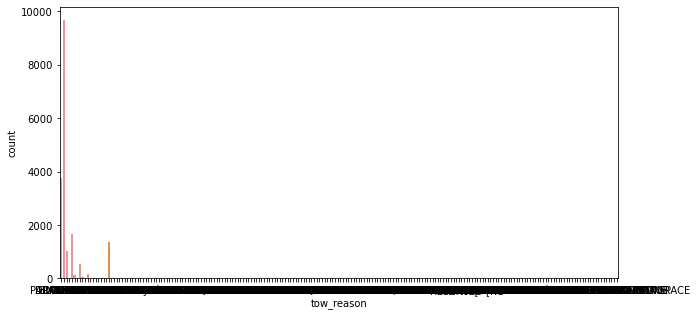

In [22]:
reason_count = towing["tow_reason"].value_counts()
print(reason_count)
reason_freq = towing["tow_reason"].value_counts(normalize = True)
print(reason_freq)
sns.countplot(x = "tow_reason", data = towing)
plt.show()

Silver Spring         8032
Gaithersburg          3045
Germantown            2333
Rockville             1998
Montgomery Village    1637
Bethesda               531
Burtonsville           303
Takoma Park            285
Damascus               157
Derwood                149
Olney                  133
Chevy Chase            115
Kensington              57
Clarksburg              42
Potomac                 29
Boyds                    6
Brookeville              4
Poolesville              3
Frederick                1
Beltsville               1
Garrett Park             1
Great Falls              1
Cabin John               1
Name: city, dtype: int64
Silver Spring         0.425785
Gaithersburg          0.161419
Germantown            0.123675
Rockville             0.105916
Montgomery Village    0.086779
Bethesda              0.028149
Burtonsville          0.016062
Takoma Park           0.015108
Damascus              0.008323
Derwood               0.007899
Olney                 0.007050
Chevy Chase  

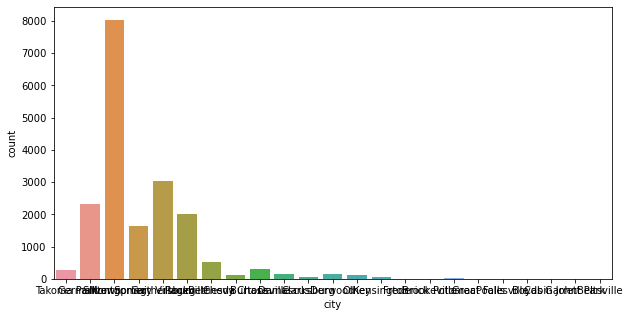

In [23]:
city_count = towing["city"].value_counts()
print(city_count)
city_freq = towing["city"].value_counts(normalize = True)
print(city_freq)
sns.countplot(x = "city", data = towing)
plt.show()

In [24]:
towing.groupby('storage_company').get_group('Speedys')

,tow_date,tow_reason,storage_company,notes,incident_date,location,city,geo_location
516,2020-05-05,FIRE,Speedys,Firelane Speedys,05/22/0005,17901 Calabar Dr,Gaithersburg,POINT (-77.164775 39.149455)
556,2020-05-05,NOP,Speedys,Speedys,05/22/0005,17901 Calabar Dr,Gaithersburg,POINT (-77.164775 39.149455)
1424,2020-02-11,FIRE,Speedys,Speedys,02/11/2020,9272 Broadwater Dr,Gaithersburg,POINT (-77.191482 39.170111)
1564,2020-02-15,RESERVED PKH,Speedys,Speedys,02/15/2020,15010 Dinsdale Dr,Silver Spring,POINT (-77.050642 39.103969)
1572,2020-02-16,PERMIT COVERED,Speedys,Permit Speedys,02/16/2020,18223 Swiss Cir,Germantown,POINT (-77.27543 39.155721)
...,...,...,...,...,...,...,...,...
17829,2021-02-04,IMP,Speedys,Speedsys,04/23/0002,19900 Buhrstone Dr,Montgomery Village,POINT (-77.212991 39.181954)
18045,2021-02-16,NOP,Speedys,Speedys,02/18/0021,8115 Fenton St,Silver Spring,POINT (-77.024011 38.991211)
18549,2021-01-21,ABN,Speedys,Abd Veh Speedys,01/23/0021,20700 Crystal Hill Cir,Germantown,POINT (-77.27628 39.198069)
18589,2021-02-23,ABN,Speedys,Exp Tag Aband Speedys,02/25/0021,13924 Valleyfield Dr,Silver Spring,POINT (-77.05598 39.103745)


In [25]:
#Group by city, a column, then get group Gaithersburg, a column value
df_city = towing.groupby("city")
df_city.first()
df_city.get_group("Gaithersburg")

,tow_date,tow_reason,storage_company,notes,incident_date,location,geo_location
6,2020-04-10,PKG,Prestige,Prestige,10/22/0004,101 Park Ave,POINT (-77.195077 39.144489)
10,2020-04-14,NOP,Henrys,Henrys,04/16/0020,950 West Side Dr,POINT (-77.204068 39.125395)
12,2020-04-01,NOP,Henrys,Henrys,01/22/0004,2 Turtle Dove Ct,POINT (-77.187088 39.177899)
14,2020-04-24,NOP,Auburn,Auburn,04/26/0020,374 N Summit Ave,POINT (-77.193068 39.149053)
15,2020-04-21,NOP,Henrys,Henrys,04/23/0020,8130 Pepperwood Ln,POINT (-77.167129 39.145024)
...,...,...,...,...,...,...,...
18834,2021-01-27,PRV,Prestige,Prestige Property,01/29/0021,17060 King James Way,POINT (-77.20637 39.13639)
18847,2021-01-27,PKG,Aubrun,Aubrun No Moccercial Pk,01/29/0021,1332 Travis View Ct,POINT (-77.22052 39.165407)
18850,2021-02-27,NOP,Henrys,In A Henrys,03/01/0021,9132 Centerway Rd,POINT (-77.18861 39.169353)
18852,2021-01-09,NOP,Big Tow,Altered Big Tow,09/23/0001,424 Girard St,POINT (-77.186318 39.14846)


In [26]:
df_multi = towing.groupby(['city', 'tow_reason'])
df_multi.first(300,)

tow_date          storage_company  \
city        tow_reason                                               
Beltsville  PKG                2021-02-28  10407 New Hampshire Ave   
Bethesda    72                 2020-07-20              Diversified   
            ABN                2020-02-03                      Vrs   
            ALTERED PERMIT     2020-07-19                  Big Tow   
            ALTERED PKG PERMIT 2020-02-26                  Big Tow   
...                                   ...                      ...   
Takoma Park NOP                2020-05-20                   Henrys   
            PARKING            2021-01-28                   Henrys   
            PKG                2020-05-18                   Henrys   
            PRV                2020-05-28                 Prestige   
            REPO               2020-02-13                      Cti   

                                                                            notes  \
city        tow_reason                                                              
Beltsville  PKG                 Carlitos Towing       Was Supposed To Be Towed...   
Bethesda    72                                   ()    Diversified         * Hr*    
            ABN                                              Ab Custom  Aba  Vrs    
            ALTERED PERMIT                              Altered Permit  Big Tow     
            ALTERED PKG PERMIT                        Altered  Permir  Big Tow      
...                                                                           ...   
Takoma Park NOP                                                       Henrys        
            PARKING                                                      Henrys     
            PKG                                                         Henrys      
            PRV                                                      Prestige       
            REPO                                Credit Acceotance   Cti Recovery    

                               incident_date              location  \
city        tow_reason                                               
Beltsville  PKG                   03/02/0021  11404 Cherry Hill Rd   
Bethesda    72                    07/22/0020      8300 Burdette Rd   
            ABN                   02/03/2020      4906 Crescent St   
            ALTERED PERMIT        07/21/0020       6811 Fairfax Rd   
            ALTERED PKG PERMIT    02/26/2020     6919 Clarendon Rd   
...                                      ...                   ...   
Takoma Park NOP                   05/22/0020             2 Seek Ct   
            PARKING               01/30/0021      400 Browning Ave   
            PKG                   05/20/0020         7411 Aspen Ct   
            PRV                   05/30/0020       1100 Linden Ave   
            REPO                  02/13/2020        7667 Maple Ave   

                                                geo_location  
city        tow_reason                                        
Beltsville  PKG                 POINT (-76.950759 39.043589)  
Bethesda    72                  POINT (-77.151758 38.991456)  
            ABN                 POINT (-77.095852 38.954231)  
            ALTERED PERMIT       POINT (-77.10122 38.978723)  
            ALTERED PKG PERMIT  POINT (-77.101329 38.978875)  
...                                                      ...  
Takoma Park NOP                 POINT (-76.994344 38.996944)  
            PARKING             POINT (-77.001194 38.995925)  
            PKG                 POINT (-76.998141 38.980389)  
            PRV                  POINT (-76.988098 38.97635)  
            REPO                POINT (-77.005497 38.983854)  

[438 rows x 6 columns]

In [27]:
towing_geo = towing["geo_location"].str.split(" ", n = 5, expand = True)
towing_geo

,0,1,2
0,POINT,(-76.998141,38.980389)
1,POINT,(-77.261484,39.179888)
2,POINT,(-77.042077,38.999696)
3,POINT,(-76.951448,39.083196)
4,POINT,(-77.204414,39.163187)
...,...,...,...
18859,POINT,(-76.939653,39.072248)
18860,POINT,(-77.06692,39.088854)
18861,POINT,(-77.06692,39.088854)
18862,POINT,(-76.999533,38.998597)


In [28]:
#create new towing dataset columns "latitude" and "longitude"
towing["longitude"] = towing_geo.iloc[:,1]
towing["longitude"] = towing["longitude"].str.replace("(", "")
towing["latitude"] = towing_geo.iloc[:,2]
towing["latitude"] = towing["latitude"].str.replace(")", "")
towing.head()

,tow_date,tow_reason,storage_company,notes,incident_date,location,city,geo_location,longitude,latitude
0,2020-05-18,PKG,Henrys,Henrys,05/20/0020,7411 Aspen Ct,Takoma Park,POINT (-76.998141 38.980389),-76.998141,38.980389
1,2020-04-13,NOP,Authorized,Authorized,04/15/0020,19757 Crystal Rock Dr,Germantown,POINT (-77.261484 39.179888),-77.261484,39.179888
2,2020-04-09,PKG,Prestige,Handicap Spot Without Placard Or Tag Presti...,09/22/0004,1970 Rosemary Hills Dr,Silver Spring,POINT (-77.042077 38.999696),-77.042077,38.999696
3,2020-04-25,PKG,Henrys,Henrys,04/27/0020,2800 Shepperton Ter,Silver Spring,POINT (-76.951448 39.083196),-76.951448,39.083196
4,2020-04-30,NOP,Henrys,Henrys,05/02/0020,18710 Walkers Choice Rd,Montgomery Village,POINT (-77.204414 39.163187),-77.204414,39.163187


In [29]:
towing.dtypes

tow_date           datetime64[ns]
tow_reason                 object
storage_company            object
notes                      object
incident_date              object
location                   object
city                       object
geo_location               object
longitude                  object
latitude                   object
dtype: object

In [30]:
#load MD shapefile: https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python/
MD_locations = gpd.read_file('/Users/elizabethclick/Downloads/tl_2020_24_tabblock20/tl_2020_24_tabblock20.shp')

In [31]:
print(MD_locations.head())
MD_locations.dtypes

  STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
0        24        021    751003      3039  240217510033039  Block 3039   
1        24        021    751002      1001  240217510021001  Block 1001   
2        24        009    861100      2007  240098611002007  Block 2007   
3        24        009    860103      1000  240098601031000  Block 1000   
4        24        021    751600      1031  240217516001031  Block 1031   

  MTFCC20  UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
0   G5040  None   None     None          S    39627         0  +39.3914109   
1   G5040  None   None     None          S   473067         0  +39.3842313   
2   G5040  None   None     None          S    23567         0  +38.5132309   
3   G5040  None   None     None          S    80883         0  +38.7433180   
4   G5040  None   None     None          S   807936         0  +39.5481425   

     INTPTLON20                                           geometry  
0  -077.408

STATEFP20       object
COUNTYFP20      object
TRACTCE20       object
BLOCKCE20       object
GEOID20         object
NAME20          object
MTFCC20         object
UR20            object
UACE20          object
UATYPE20        object
FUNCSTAT20      object
ALAND20          int64
AWATER20         int64
INTPTLAT20      object
INTPTLON20      object
geometry      geometry
dtype: object

In [32]:

MC_locations = pd.DataFrame(MD_locations[(MD_locations['COUNTYFP20'] == "031")])
MC_locations.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
315,24,031,701509,1005,240317015091005,Block 1005,G5040,None,None,None,S,32483,0,+39.0282492,-076.9737754,"POLYGON ((-76.97514 39.02898, -76.97444 39.029..."
316,24,031,700902,1009,240317009021009,Block 1009,G5040,None,None,None,S,35565,0,+39.0959369,-077.1459908,"POLYGON ((-77.14780 39.09699, -77.14778 39.097..."
317,24,031,700611,1011,240317006111011,Block 1011,G5040,None,None,None,S,23391,0,+39.1534410,-077.2955317,"POLYGON ((-77.29639 39.15339, -77.29573 39.153..."
318,24,031,700610,1015,240317006101015,Block 1015,G5040,None,None,None,S,1965,0,+39.1335855,-077.2671475,"POLYGON ((-77.26768 39.13293, -77.26733 39.133..."
319,24,031,700309,2000,240317003092000,Block 2000,G5040,None,None,None,S,61734,1125,+39.1825560,-077.2674083,"POLYGON ((-77.26957 39.18347, -77.26870 39.183..."


In [33]:
#truncate BLOCKCE20 to 1st digit to replace 4-digit with proper 1-digit block
MC_locations['BLOCKTRUNC'] = MC_locations["BLOCKCE20"].astype(str).str[0]
MC_locations.head()
#concatenate tract and block codes for matching census data
MC_locations["codes"] = MC_locations['TRACTCE20']+MC_locations["BLOCKTRUNC"]
MC_locations.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,BLOCKTRUNC,codes
315,24,031,701509,1005,240317015091005,Block 1005,G5040,None,None,None,S,32483,0,+39.0282492,-076.9737754,"POLYGON ((-76.97514 39.02898, -76.97444 39.029...",1,7015091
316,24,031,700902,1009,240317009021009,Block 1009,G5040,None,None,None,S,35565,0,+39.0959369,-077.1459908,"POLYGON ((-77.14780 39.09699, -77.14778 39.097...",1,7009021
317,24,031,700611,1011,240317006111011,Block 1011,G5040,None,None,None,S,23391,0,+39.1534410,-077.2955317,"POLYGON ((-77.29639 39.15339, -77.29573 39.153...",1,7006111
318,24,031,700610,1015,240317006101015,Block 1015,G5040,None,None,None,S,1965,0,+39.1335855,-077.2671475,"POLYGON ((-77.26768 39.13293, -77.26733 39.133...",1,7006101
319,24,031,700309,2000,240317003092000,Block 2000,G5040,None,None,None,S,61734,1125,+39.1825560,-077.2674083,"POLYGON ((-77.26957 39.18347, -77.26870 39.183...",2,7003092


In [34]:
MC_locations.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9513 entries, 315 to 83656
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP20   9513 non-null   object  
 1   COUNTYFP20  9513 non-null   object  
 2   TRACTCE20   9513 non-null   object  
 3   BLOCKCE20   9513 non-null   object  
 4   GEOID20     9513 non-null   object  
 5   NAME20      9513 non-null   object  
 6   MTFCC20     9513 non-null   object  
 7   UR20        0 non-null      object  
 8   UACE20      0 non-null      object  
 9   UATYPE20    0 non-null      object  
 10  FUNCSTAT20  9513 non-null   object  
 11  ALAND20     9513 non-null   int64   
 12  AWATER20    9513 non-null   int64   
 13  INTPTLAT20  9513 non-null   object  
 14  INTPTLON20  9513 non-null   object  
 15  geometry    9513 non-null   geometry
 16  BLOCKTRUNC  9513 non-null   object  
 17  codes       9513 non-null   object  
dtypes: geometry(1), int64(2), object(15)
memory u

In [35]:
census = gpd.GeoDataFrame(tractDF.merge(MC_locations, how='inner', on=None, left_on="block group", right_on="codes", left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None))
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7798 entries, 0 to 7797
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   NAME         7798 non-null   object  
 1   hh_income    7798 non-null   object  
 2   pop_total    7798 non-null   object  
 3   pop_black    7798 non-null   object  
 4   state        7798 non-null   object  
 5   county       7798 non-null   object  
 6   tract        7798 non-null   object  
 7   block group  7798 non-null   object  
 8   STATEFP20    7798 non-null   object  
 9   COUNTYFP20   7798 non-null   object  
 10  TRACTCE20    7798 non-null   object  
 11  BLOCKCE20    7798 non-null   object  
 12  GEOID20      7798 non-null   object  
 13  NAME20       7798 non-null   object  
 14  MTFCC20      7798 non-null   object  
 15  UR20         0 non-null      object  
 16  UACE20       0 non-null      object  
 17  UATYPE20     0 non-null      object  
 18  FUNCSTAT20   7798 no

In [36]:
towing_gdf = gpd.GeoDataFrame(
    towing, geometry=gpd.points_from_xy(towing.longitude, towing.latitude))
towing_gdf.head()


,tow_date,tow_reason,storage_company,notes,incident_date,location,city,geo_location,longitude,latitude,geometry
0,2020-05-18,PKG,Henrys,Henrys,05/20/0020,7411 Aspen Ct,Takoma Park,POINT (-76.998141 38.980389),-76.998141,38.980389,POINT (-76.99814 38.98039)
1,2020-04-13,NOP,Authorized,Authorized,04/15/0020,19757 Crystal Rock Dr,Germantown,POINT (-77.261484 39.179888),-77.261484,39.179888,POINT (-77.26148 39.17989)
2,2020-04-09,PKG,Prestige,Handicap Spot Without Placard Or Tag Presti...,09/22/0004,1970 Rosemary Hills Dr,Silver Spring,POINT (-77.042077 38.999696),-77.042077,38.999696,POINT (-77.04208 38.99970)
3,2020-04-25,PKG,Henrys,Henrys,04/27/0020,2800 Shepperton Ter,Silver Spring,POINT (-76.951448 39.083196),-76.951448,39.083196,POINT (-76.95145 39.08320)
4,2020-04-30,NOP,Henrys,Henrys,05/02/0020,18710 Walkers Choice Rd,Montgomery Village,POINT (-77.204414 39.163187),-77.204414,39.163187,POINT (-77.20441 39.16319)


In [37]:
towing_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18864 entries, 0 to 18863
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tow_date         18864 non-null  datetime64[ns]
 1   tow_reason       18864 non-null  object        
 2   storage_company  18864 non-null  object        
 3   notes            18864 non-null  object        
 4   incident_date    18864 non-null  object        
 5   location         18864 non-null  object        
 6   city             18864 non-null  object        
 7   geo_location     18864 non-null  object        
 8   longitude        18864 non-null  object        
 9   latitude         18864 non-null  object        
 10  geometry         18864 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1), object(9)
memory usage: 1.6+ MB


In [ ]:
#from turfpy.measurement import boolean_point_in_polygon
#from geojson import Point, MultiPolygon, Feature
#towing_gdf["codes"] = [[] for r in range(len(towing_gdf))]
#x=-1
#rowcount_x = len(towing_gdf)-1
#rowcount_y = len(census) -1
#print(x)
#while x < rowcount_x :
#    x = x+1
#    y = -1
#    point = Feature(geometry=towing_gdf.iloc[x,10])
#    print(y)
#    while y < rowcount_y :
#        for x in towing_gdf.iloc[x,11] :
#            polygon = Feature(geometry=census.iloc[y,23])
#            if polygon.contains(point) :
#                towing_gdf.iloc[x,11] = census.iloc[y,25]         
#                y=-1
#                print(towing_gdf.iloc[x,11])
#           else :
#               y=y+1
#               print("not found")
            
##INCOMPATIBILITY BUG IN SHAPELY VS. GEOPANDAS PACKAGES


-1
-1


In [ ]:
#main_gdf = census.merge(towing, how='right', on=None, left_on=["INTPTLON20", "INTPTLAT20"], right_on=["longitude", "latitude"], left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

In [ ]:
#main_gdf.tail()

